In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'architectural-styles-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F849193%2F1448722%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240528%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240528T200152Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7518ea499177fe6bd57282153b108f7b4c91941b04abd6f90a0e7e4d7ab2ff44102c6b523fa5b00b9baf1fb9b601d0bca63d73afcc1b2316308d16fcffbd0bca96cfa9f3bfa8365ecb944bdae76c3033c8a7cb8d9228d4a033ebb28d5b5d01893ffa8233667893513e4c72bfa94dfe6aff9df7f64a1e0230dbcefd74312453ff2a8bcfdbe553c4b5f7e276f864d315c2eb8b79ce9fc9856f4a3de9701c49bade71daecbd8a9c97414556f21c748eb37c435da317d964f6939a56251bd23cbb8a00ce74ff0d1d6c4a13cff5ae51a093f66c8700226bf5bb0be9caa208374e599083b634ad24db6dc64f63c3442487170f3c7f504921cdcff90c987379f95a70dd'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1677638078 bytes downloaded
Downloaded and uncompressed: architectural-styles-dataset
Data source import complete.


In [ ]:
import cv2
import os
import glob
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import itertools
from sklearn.metrics import confusion_matrix

In [ ]:
warnings.filterwarnings("ignore")

# ensure that any edits to libraries you make are reloaded here automatically
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
styles = [
    'Achaemenid architecture',
    'American craftsman style',
    'American Foursquare architecture',
    'Ancient Egyptian architecture',
    'Art Deco architecture',
    'Art Nouveau architecture',
    'Baroque architecture',
    'Bauhaus architecture',
    'Beaux-Arts architecture',
    'Byzantine architecture',
    'Chicago school architecture',
    'Colonial architecture',
    'Deconstructivism',
    'Edwardian architecture',
    'Georgian architecture',
    'Gothic architecture',
    'Greek Revival architecture',
    'International style',
    'Novelty architecture',
    'Palladian architecture',
    'Postmodern architecture',
    'Queen Anne architecture',
    'Romanesque architecture',
    'Russian Revival architecture',
    'Tudor Revival architecture'
]

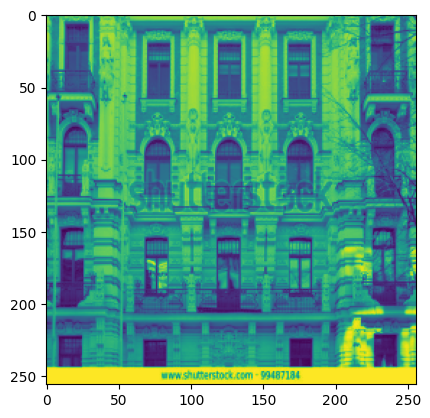

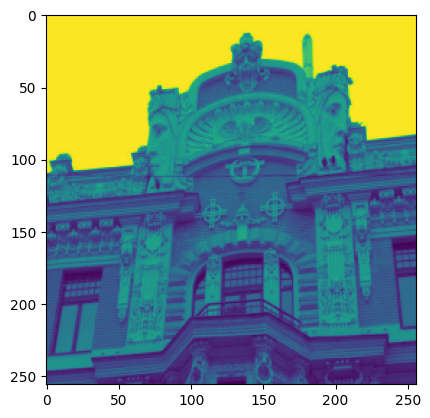

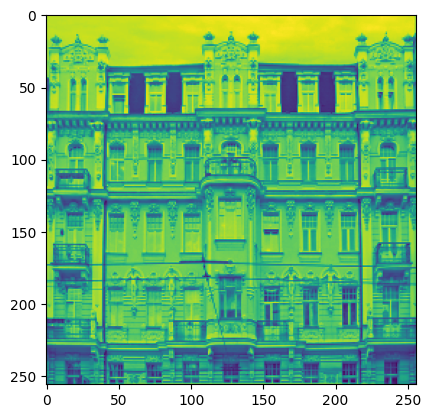

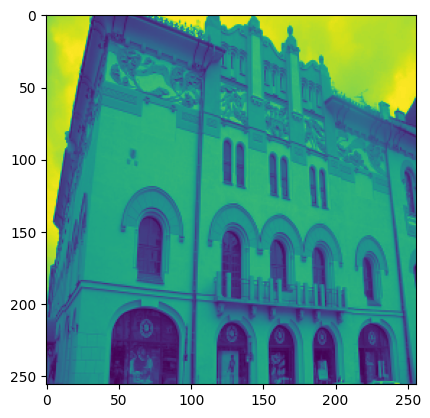

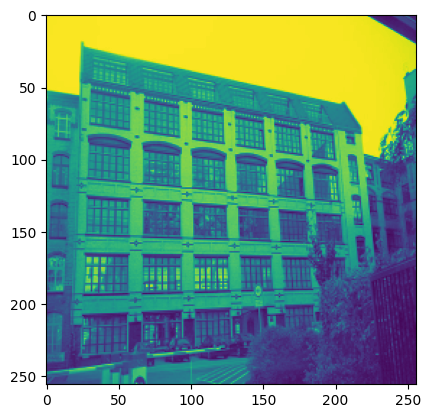

In [ ]:
# Explore data

file_jpg = glob.glob(f'../input/architectural-styles-dataset/**/{styles[5]}/*.jpg', recursive=True)

dim = (256,256)

for i, f in enumerate(file_jpg[:5]):
    img = cv2.imread(f)
    img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(img)
    plt.show()

In [ ]:
# Prep data

# - Canny edges to eliminate noise

X = []
y = []

dim = (256,256)

for style in styles[:4]:
    file_jpg = glob.glob(f'../input/architectural-styles-dataset/**/{style}/*.jpg', recursive=True)

    for i, f in enumerate(file_jpg):
        img = cv2.imread(f)
        img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.array(img)
        img = img.astype('float32')
        img /= 255
        X.append(img)
        y.append(style)


In [ ]:
# Cast labels to integers
y = [styles.index(label) for label in y]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
len(X_train), len(X_test), len(X_valid), len(y_train), len(y_test), len(y_valid)

(1496, 468, 374, 1496, 468, 374)

In [ ]:
X_train[0], y_train[0]

(array([[0.81960785, 0.81960785, 0.80784315, ..., 0.1764706 , 0.2       ,
         0.08627451],
        [0.827451  , 0.827451  , 0.8039216 , ..., 0.14901961, 0.25882354,
         0.08627451],
        [0.827451  , 0.827451  , 0.80784315, ..., 0.14901961, 0.24313726,
         0.05098039],
        ...,
        [0.47058824, 0.42352942, 0.32941177, ..., 0.43529412, 0.40784314,
         0.42745098],
        [0.3372549 , 0.3372549 , 0.25490198, ..., 0.21568628, 0.2627451 ,
         0.32156864],
        [0.3647059 , 0.3764706 , 0.28235295, ..., 0.2509804 , 0.27450982,
         0.27058825]], dtype=float32),
 2)

In [ ]:
# Building sequential model

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [256, 256]),
    keras.layers.Dense(100, activation = 'relu'),
    keras.layers.Dense(70, activation = 'relu'),
    keras.layers.Dense(50, activation = 'relu'),
    keras.layers.Dense(20, activation = 'relu'),
    keras.layers.Dense(10, activation = 'softmax')
])


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_5 (Dense)             (None, 100)               6553700   
                                                                 
 dense_6 (Dense)             (None, 70)                7070      
                                                                 
 dense_7 (Dense)             (None, 50)                3550      
                                                                 
 dense_8 (Dense)             (None, 20)                1020      
                                                                 
 dense_9 (Dense)             (None, 10)                210       
                                                                 
Total params: 6565550 (25.05 MB)
Trainable params: 656

In [ ]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

In [ ]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_valid = np.asarray(X_valid)
y_valid = np.asarray(y_valid)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

type(X_train), type(y_train)

(numpy.ndarray, numpy.ndarray)

In [ ]:
model_history = model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 50)

Epoch 1/50
47/47 [==============================] - 10s 176ms/step - loss: 3.8570 - accuracy: 0.3055 - val_loss: 1.3934 - val_accuracy: 0.3850
Epoch 2/50
47/47 [==============================] - 6s 119ms/step - loss: 1.4572 - accuracy: 0.4184 - val_loss: 1.3442 - val_accuracy: 0.3690
Epoch 3/50
47/47 [==============================] - 5s 97ms/step - loss: 1.2111 - accuracy: 0.4499 - val_loss: 1.1919 - val_accuracy: 0.4465
Epoch 4/50
47/47 [==============================] - 6s 126ms/step - loss: 1.3100 - accuracy: 0.4579 - val_loss: 1.4164 - val_accuracy: 0.4439
Epoch 5/50
47/47 [==============================] - 5s 97ms/step - loss: 1.2483 - accuracy: 0.4599 - val_loss: 1.2709 - val_accuracy: 0.4358
Epoch 6/50
47/47 [==============================] - 5s 98ms/step - loss: 1.0297 - accuracy: 0.5167 - val_loss: 1.0866 - val_accuracy: 0.4519
Epoch 7/50
47/47 [==============================] - 6s 126ms/step - loss: 1.0005 - accuracy: 0.5341 - val_loss: 1.2198 - val_accuracy: 0.4545
Epoch 8/

In [ ]:
model.evaluate(X_test, y_test)

15/15 [==============================] - 0s 24ms/step - loss: 0.9031 - accuracy: 0.7158


[0.9030740261077881, 0.7158119678497314]

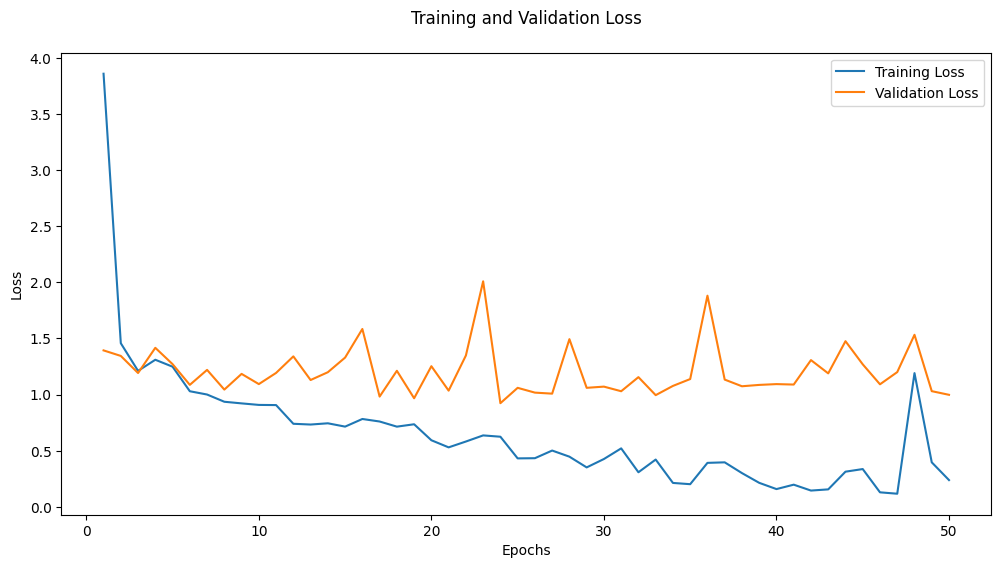

In [ ]:
# Plot training and validation lost

plt.figure(figsize = (12, 6))
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epoch = range(1, 51)
sns.lineplot(x = epoch, y = train_loss, label = 'Training Loss')
sns.lineplot(x = epoch, y = val_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'best')
plt.show()

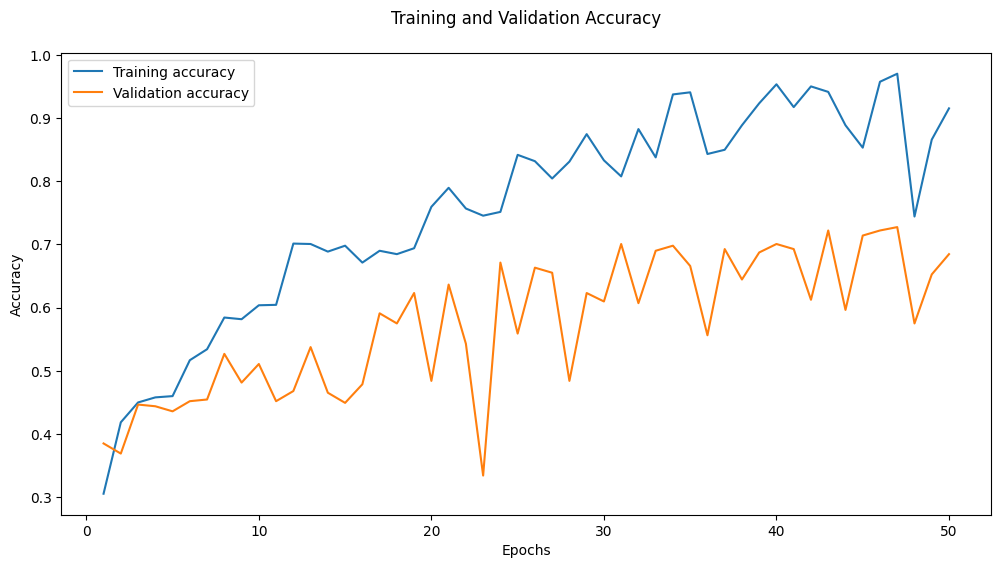

In [ ]:
# Plot training and validation accuracy

plt.figure(figsize = (12, 6))
train_loss = model_history.history['accuracy']
val_loss = model_history.history['val_accuracy']
epoch = range(1, 51)
sns.lineplot(x = epoch, y = train_loss, label = 'Training accuracy')
sns.lineplot(x = epoch, y = val_loss, label = 'Validation accuracy')
plt.title('Training and Validation Accuracy\n')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.show()

In [ ]:
y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)

y_pred, y_test

15/15 [==============================] - 0s 23ms/step


(array([3, 2, 0, 2, 3, 2, 2, 3, 3, 3, 1, 3, 1, 0, 2, 2, 1, 2, 1, 2, 0, 0,
        0, 2, 3, 0, 2, 1, 2, 3, 0, 2, 3, 2, 2, 0, 1, 0, 2, 2, 3, 0, 2, 2,
        0, 2, 3, 2, 3, 0, 2, 2, 2, 1, 3, 1, 2, 3, 1, 3, 1, 2, 2, 1, 3, 1,
        0, 2, 3, 1, 2, 0, 2, 3, 0, 0, 0, 3, 0, 0, 0, 2, 0, 1, 2, 0, 0, 3,
        3, 2, 1, 2, 0, 3, 0, 0, 0, 3, 0, 0, 3, 1, 2, 2, 2, 0, 0, 0, 3, 0,
        3, 2, 3, 3, 3, 0, 0, 2, 2, 3, 0, 3, 3, 2, 0, 2, 3, 2, 2, 3, 1, 0,
        0, 0, 0, 0, 3, 3, 0, 2, 0, 2, 3, 0, 2, 3, 2, 0, 2, 3, 0, 3, 2, 3,
        3, 1, 0, 2, 0, 2, 3, 2, 0, 1, 2, 0, 1, 2, 1, 3, 3, 0, 0, 3, 0, 3,
        0, 1, 3, 3, 1, 2, 0, 3, 0, 3, 1, 0, 2, 3, 0, 2, 1, 2, 2, 3, 2, 3,
        3, 2, 3, 2, 3, 3, 3, 3, 0, 2, 3, 2, 0, 2, 3, 0, 3, 0, 3, 3, 2, 0,
        3, 3, 2, 3, 0, 2, 1, 2, 2, 3, 1, 0, 1, 3, 3, 2, 0, 0, 2, 3, 2, 2,
        3, 2, 3, 0, 1, 0, 3, 3, 2, 3, 3, 1, 2, 2, 3, 2, 2, 1, 2, 3, 2, 2,
        0, 0, 2, 0, 3, 0, 1, 3, 1, 3, 0, 1, 0, 1, 1, 0, 0, 3, 0, 3, 2, 0,
        3, 2, 2, 0, 3, 2, 2, 1, 0, 0, 

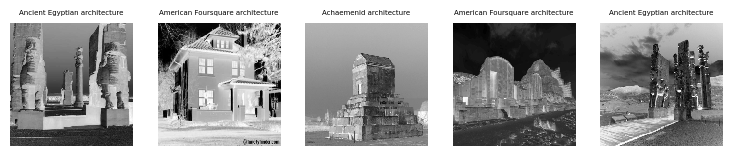

In [ ]:
plt.figure(figsize=(9.2, 4.4))
for index, image in enumerate(X_test[:5]):
    plt.subplot(1, 5, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(styles[y_pred[index]], fontsize=5)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [ ]:
model.save('ArchANN.h5')